In [1]:
%load_ext autoreload
%autoreload 2
%cd ../..
%pwd

from numba import cuda
assert cuda.is_available(), "Change the colab instance type to T4."

/home/PangeAI/Documents/work/scalexa/pangeaai/optimize-cosine


In [2]:
from matchms.importing import load_from_mgf
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from cudams.utils import download
from pathlib import Path
from cudams.similarity import CudaCosineGreedy
from numba import cuda
assert cuda.is_available()

In [3]:
match_limit = 1024
max_peaks = 1024
batch_size = 2048
threshold = .75

In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm
from matchms.filtering import reduce_to_number_of_peaks, \
    default_filters, normalize_intensities
from matchms.filtering import add_fingerprint

    
spectra_file = download('GNPS-LIBRARY.mgf')
def parse_spectrum(spectrum):
    ## Uncomment if you want default filters enabled - add more if you need them.
    spectrum = default_filters(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks)
    spectrum = normalize_intensities(spectrum)
    return spectrum

limit = 512
spectrums = tuple(s for _, s in zip(range(limit), load_from_mgf(spectra_file)))
spectrums = Parallel(-1)(delayed(parse_spectrum)(spec) for spec in tqdm(spectrums))
spectrums = [spe for spe in spectrums if spe is not None]
spectrums = [add_fingerprint(spe, nbits=256) for spe in spectrums]

100%|██████████| 512/512 [00:02<00:00, 212.91it/s]


In [5]:
# Pairwise similarity between all
references, queries = spectrums, spectrums

print(f"We have {len(references) + len(queries):.3e} spectra")
print(f"Pairwise comparisons have {len(references)*len(queries):.3e} pairs in total")

We have 1.024e+03 spectra
Pairwise comparisons have 2.621e+05 pairs in total


In [7]:

from matchms import calculate_scores
from matchms.similarity import CosineGreedy, \
    FingerprintSimilarity, IntersectMz, \
    ModifiedCosine, ParentMassMatch, PrecursorMzMatch

similarity_function=FingerprintSimilarity('jaccard')
# similarity_function=IntersectMz()
# similarity_function=ModifiedCosine()
# similarity_function=ParentMassMatch()
# similarity_function=PrecursorMzMatch()

scores = calculate_scores(references=references,
                          queries=queries,
                          similarity_function=similarity_function,
                          is_symmetric=True).to_array()
print(f"Size of matrix of computed similarities: {scores.shape}")

Size of matrix of computed similarities: (512, 512)


In [ ]:
from cudams.similarity import CudaFingerprintSimilarity

similarity_function = CudaFingerprintSimilarity()
scores_cu = calculate_scores(
    references=references,
    queries=queries,
    similarity_function=similarity_function,
    is_symmetric=True
).to_array()
print(f"Size of matrix of computed similarities: {scores.shape}")

In [25]:
similarity_function = CosineGreedy()
scores_b = calculate_scores(
    references=references,
    queries=queries,
    similarity_function=similarity_function,
    is_symmetric=True
).to_array()

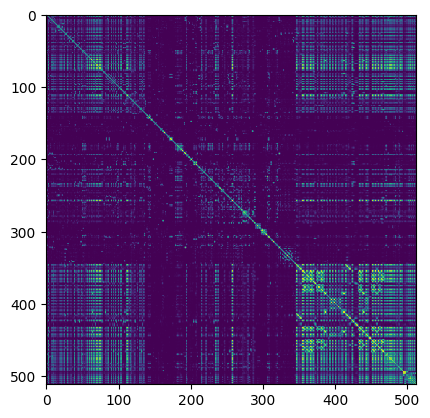

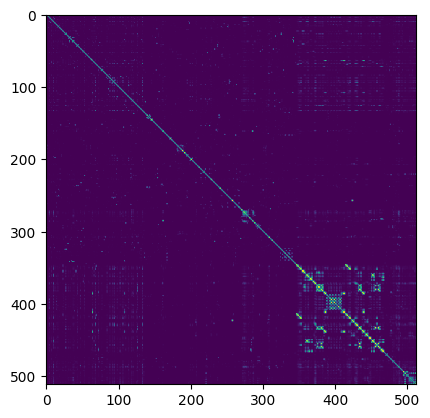

In [34]:
import numpy as np
import matplotlib.pyplot as plt
x = scores['ModifiedCosine_score']
plt.imshow(x)
plt.figure()
x = (scores_b['CosineGreedy_score'])
plt.imshow(x)
 

In [29]:
scores_b.dtype

dtype([('CosineGreedy_score', '<f8'), ('CosineGreedy_matches', '<i8')])

Perform calculations using the using original `matchms` functions.

In [4]:
scores = calculate_scores(references=spectrums,
                          queries=spectrums,
                          similarity_function=CosineGreedy(),
                          is_symmetric=True)
print(f"Size of matrix of computed similarities: {scores.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches = scores.scores_by_query(query, 'CosineGreedy_score', sort=True)

# Print the calculated scores for each spectrum pair
for (reference, (score, matches)) in best_matches[:10]:
    # Ignore scores between same spectrum
    if reference is not query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print("----------------------------")

Size of matrix of computed similarities: (76, 76, 2)
Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
----------------------------
Reference scan id: 1772
Query scan id: 2161
Score: 0.1037
Number of matching peaks: 4
----------------------------
Reference scan id: 2284
Qu

In [6]:
# Default tolerance and other arguments are the same

cosine_greedy_kernel = CudaCosineGreedy(batch_size=512)
scores_cu = calculate_scores(
    references=spectrums,
    queries=spectrums, 
    similarity_function=cosine_greedy_kernel)

We use the CUDA-calculated results in the same fashion:

In [7]:
# This computed all-vs-all similarity scores, the array of which can be accessed as scores.scores
print(f"Size of matrix of computed similarities: {scores_cu.scores.shape}")

# Matchms allows to get the best matches for any query using scores_by_query
query = spectrums[15]  # just an example
best_matches_cu = scores_cu.scores_by_query(query, 'CudaCosineGreedy_score', sort=True)

Size of matrix of computed similarities: (76, 76, 3)


In [8]:

# Print the calculated scores_cu for each spectrum pair
for (reference, (score, matches, overflow)) in best_matches_cu[:10]:
    # Ignore scores_cu between same spectrum
    if reference != query:
        print(f"Reference scan id: {reference.metadata['scans']}")
        print(f"Query scan id: {query.metadata['scans']}")
        print(f"Score: {score:.4f}")
        print(f"Number of matching peaks: {matches}")
        print(f"Did GPU overflow at this pair: {overflow}")
        print("----------------------------")


Reference scan id: 613
Query scan id: 2161
Score: 0.8646
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 603
Query scan id: 2161
Score: 0.8237
Number of matching peaks: 14
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2160
Query scan id: 2161
Score: 0.8015
Number of matching peaks: 25
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2362
Query scan id: 2161
Score: 0.2923
Number of matching peaks: 7
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2598
Query scan id: 2161
Score: 0.2231
Number of matching peaks: 5
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 2594
Query scan id: 2161
Score: 0.1761
Number of matching peaks: 3
Did GPU overflow at this pair: 0
----------------------------
Reference scan id: 1944
Query scan id: 2161
Score: 0.1396
Number of matching peaks: 5
Did GPU overflow at this 

We make sure that results from both matchms and CudaCosineGreedy are equal.

In [9]:
for a, b in zip(best_matches[:10], best_matches_cu[:10]):
    reference, (score_a, matches_a) = a
    reference, (score_b, matches_b, overflow_b) = b
    if reference != query:
        # If we didn't overflow
        if not overflow_b:
            assert np.isclose(score_a, score_b), ("score error", score_a, score_b)
            assert np.isclose(matches_a, matches_b), ('match error', matches_a, matches_b)
        # If overflow, score must be leq
        else:
            assert score_a >= score_b
            assert matches_a >= matches_b